# Transfer Learning Model for Text Classification (Word2vec)

In [28]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras.layers import Conv1D, GlobalMaxPooling1D
from livelossplot import PlotLossesKeras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

# Read Data

In [29]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

In [30]:
hub_model = "https://tfhub.dev/google/Wiki-words-250/1"

In [31]:
def create_text_embedding(hub_model, input_sentences):
        
    SEQ_LENGTH = max(map(len, input_sentences))
    EMBEDDING_DIM = 250

    with tf.Graph().as_default() as g:

        embed_layer = hub.Module(hub_model,
        trainable=False, name='text_embedding')

        sentences = tf.placeholder(dtype=tf.string, shape=(None, SEQ_LENGTH))
        batch_size = tf.shape(sentences)[0]

        flat_sentences = tf.reshape(sentences, [-1])

        embeddings = embed_layer(flat_sentences)

        sentence_embedding = tf.reshape(embeddings, 
                                      [batch_size, SEQ_LENGTH, EMBEDDING_DIM])

        with tf.Session(graph=g) as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            output = sess.run(sentence_embedding, feed_dict={
                sentences: input_sentences
            })
            
    return output

In [32]:
sentences = ["cat is on the mat", "dog is in the fog", 
             "padded sentence UNK UNK UNK"]
sentences = [s.split() for s in sentences]

In [33]:
sentences_em = create_text_embedding(hub_model, sentences)

INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/var/folders/8r/9vxhtq8550l2kkn3qqsng88r0000gn/T/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


In [74]:
sentences_em.shape

(3, 5, 250)

In [75]:
sentences_em[0]

array([[-0.09022635, -0.05926817,  0.09362827, ..., -0.07516086,
         0.05431775, -0.07635543],
       [-0.02643044, -0.1691547 ,  0.04513412, ..., -0.02164096,
         0.00400387, -0.02354614],
       [-0.00483655, -0.06458678, -0.02172526, ...,  0.02054301,
         0.0117408 ,  0.01072438],
       [-0.03488984, -0.12522927,  0.01865043, ..., -0.01779286,
         0.03092172, -0.01291556],
       [ 0.04126915, -0.01120683, -0.03439177, ...,  0.00522323,
         0.00323421,  0.05423511]], dtype=float32)

In [76]:
path = '../Final Project/'

In [77]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [78]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [79]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [80]:
# Get words
X = dataTraining['plot']
X_pad = [text_to_word_sequence(x) for x in X.tolist()]

In [81]:
X_pad

[['most',
  'is',
  'the',
  'story',
  'of',
  'a',
  'single',
  'father',
  'who',
  'takes',
  'his',
  'eight',
  'year',
  'old',
  'son',
  'to',
  'work',
  'with',
  'him',
  'at',
  'the',
  'railroad',
  'drawbridge',
  'where',
  'he',
  'is',
  'the',
  'bridge',
  'tender',
  'a',
  'day',
  'before',
  'the',
  'boy',
  'meets',
  'a',
  'woman',
  'boarding',
  'a',
  'train',
  'a',
  'drug',
  'abuser',
  'at',
  'the',
  'bridge',
  'the',
  'father',
  'goes',
  'into',
  'the',
  'engine',
  'room',
  'and',
  'tells',
  'his',
  'son',
  'to',
  'stay',
  'at',
  'the',
  'edge',
  'of',
  'the',
  'nearby',
  'lake',
  'a',
  'ship',
  'comes',
  'and',
  'the',
  'bridge',
  'is',
  'lifted',
  'though',
  'it',
  'is',
  'supposed',
  'to',
  'arrive',
  'an',
  'hour',
  'later',
  'the',
  'train',
  'happens',
  'to',
  'arrive',
  'the',
  'son',
  'sees',
  'this',
  'and',
  'tries',
  'to',
  'warn',
  'his',
  'father',
  'who',
  'is',
  'not',
  'able

In [82]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [83]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [84]:
y_genres.shape

(7895, 24)

In [85]:
X_pad = pad_sequences(X_pad, dtype='str', value=0)

In [86]:
X_pad

array([['0.0', '0.0', '0.0', ..., 'this', 'tumultuous', 'film'],
       ['0.0', '0.0', '0.0', ..., 'video', 'store', 'clerk'],
       ['0.0', '0.0', '0.0', ..., 'year', 'old', 'nephew'],
       ..., 
       ['0.0', '0.0', '0.0', ..., 'takes', 'a', 'hand'],
       ['0.0', '0.0', '0.0', ..., 'during', 'the', 'move'],
       ['0.0', '0.0', '0.0', ..., 'pixie', 'dust', 'tree']],
      dtype='<U32')

In [87]:
X_pad.shape

(7895, 1753)

In [88]:
X_em = create_text_embedding(hub_model, X_pad)

INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/var/folders/8r/9vxhtq8550l2kkn3qqsng88r0000gn/T/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


In [89]:
X_em.shape

(7895, 1753, 250)

In [90]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_em, y_genres, test_size=0.3, random_state=42)

In [91]:
X_train.shape

(5526, 1753, 250)

In [92]:
X_test.shape

(2369, 1753, 250)

In [93]:
y_train_genres.shape

(5526, 24)

In [94]:
y_test_genres.shape

(2369, 24)

In [95]:
model = Sequential()
model.add(Conv1D(200, 2, padding='same', strides=1, input_shape=X_em.shape[1:]))
model.add(Activation('relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(24))
model.add(Activation('sigmoid'))

model.compile("rmsprop", "categorical_crossentropy", metrics=["accuracy"])

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1753, 200)         100200    
_________________________________________________________________
activation_7 (Activation)    (None, 1753, 200)         0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               51456     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                6168      
__________

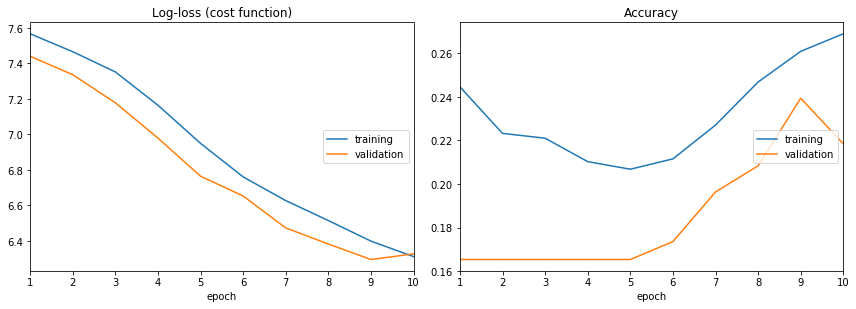

In [98]:
h = History()
model.fit(X_em, y_genres,
          epochs=10, batch_size=500, verbose=0, callbacks=[h, PlotLossesKeras()],
          validation_split=0.2)

In [99]:
h.history['val_acc'][-1]

0.21849271646589324

## Comments:
### For this model we configure various parameters for optimization that, but the model does not show improvement. For this reason we dnt used this model to load results in Kaggle competition.